In [1]:
import torch
from utils import *
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [2]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

embedding_dir = pathlib.Path('./embeddings')
antipatterns_dict = get_antipattern_dict(embedding_dir)
labels, name2label, label2name = get_labels(antipatterns_dict)
_ = get_embeddings(labels)

In [3]:
class PredictionHead(nn.Module):
    def __init__(self, embedding_dim, conv_out_dim, lstm_hidden, n_labels, filter_size=3, drop_rate_conv=0.3, drop_rate_lstm=0.5):
        super(PredictionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_dim,
                      conv_out_dim,
                      filter_size,
                      padding=filter_size // 2
                     ),
            nn.ReLU(),
            nn.Dropout(drop_rate_conv)
        )
        self.biLSTM = nn.LSTM(
            input_size=conv_out_dim,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )    
        self.out = nn.Linear(2*lstm_hidden, n_labels)
        self.dropout = nn.Dropout(drop_rate_lstm)
    def forward(self, x):
        # Input: Tensor([batch_size, embedding_dim, max_seq])
        
        # Expected: Tensor([batch_size, conv_out_dim, max_seq])
        x = self.conv(x)
        x = self.dropout(x)
        
        # Expected: Tensor([batch_size, max_seq, conv_out_dim])
        x = x.permute(0, 2, 1)

        # Expected: Tensor([batch_size, max_seq, 2*hidden_size])
        outputs, (hn, cn) = self.biLSTM(x)
        cat = torch.cat([hn[0], hn[1]], dim=-1)
        return self.out(self.dropout(cat))

In [4]:
class EmbeddingDataset(Dataset):
    def __init__(self, labels, names):
        self.labels = labels
        self.names = sorted(names, key=lambda x: self.labels[x][-1].shape[1])
        
    def __getitem__(self, idx):
        *labels, _, emb = self.labels[self.names[idx]]
        return torch.FloatTensor(emb), np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.names)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(list(labels.keys()), test_size=0.2, random_state=42)

In [6]:
def collate_fn(batch):
    max_sequence_len = max([x[0].shape[1] for x in batch])
    emb_dim = batch[0][0].shape[0]
    sequence_padded = torch.zeros([len(batch), emb_dim, max_sequence_len])
    ys = []
    for i, (X, y) in enumerate(batch):
        sequence_padded[i,:,:X.shape[-1]] = X
        ys.append(y)
    return sequence_padded, torch.Tensor(ys)

In [7]:
from sklearn.metrics import roc_curve
import numpy as np


def get_thresholds_multiclass(predictions, target):
    thresholds = []
    for i in range(predictions.shape[1]):
        fpr, tpr, threshes = roc_curve(target.T[i], predictions.T[i])
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        thresholds.append(threshes[ix])
    return thresholds


# Requires two tensors of size [batch_size, n_classes] and a vector of size [n_classes]
def get_accuracy_multiclass(predictions, target, thresholds=None):
    if thresholds is None:
        thresholds = get_thresholds_multiclass(predictions, target)
    predictions = predictions.T
    target = target.T
    correct = 0
    for i in range(predictions.shape[0]):
        predictions[i] = predictions[i] > thresholds[i]
        correct += np.sum(predictions[i] == target[i])
    return thresholds, correct / (predictions.shape[0] * predictions.shape[1])

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim = 384
conv_out_dim = 128
lstm_hidden = 128
n_labels = len(name2label)

lr = 1e-3
epochs = 3
batch_size = 16

model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

train_dataset = EmbeddingDataset(labels, train)
valid_dataset = EmbeddingDataset(labels, test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
thresholds = np.repeat(0.5, n_labels)

In [9]:
def train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        model.zero_grad()
        lbls.append(y)
        X, y = X.to(device), y.to(device)
        
        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        acc_preds = (out > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(acc_preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Accuracy [{acc:.2f}]')   
    return losses_train

In [10]:
def train_step(model, train_loader, loss_func, optimizer, device):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for X, y in pbar:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        out = model(X)
        
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (out > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_train

In [11]:
def valid_step(model, train_loader, loss_func, optimizer, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        out = model(X)

        loss = loss_func(out, y)
        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (out > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_valid.append(loss.item())
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_valid

In [12]:
def valid_step_with_roc(model, train_loader, loss_func, optimizer, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    preds, lbls = [], []
    for X, y in pbar:
        lbls.append(y)
        X, y = X.to(device), y.to(device)
        
        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)
        
        # make predictions
        y = y.reshape(-1).cpu().numpy()
        acc_preds = (out > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(acc_preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_valid.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Accuracy [{acc:.2f}]')
    thresholds, _ = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
    return losses_valid, thresholds

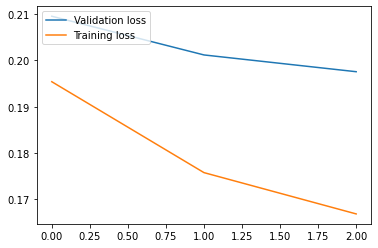

In [13]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step(model, train_loader, loss_func, optimizer, device)
    losses_valid = valid_step(model, valid_loader, loss_func, optimizer, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc ="upper left") 
plt.show()